<span style="font-family: Arial; font-size:1.6em;color:blue;"><b> Desafío 3 </b><br>
Comisión 1120-ed-13</p>

--------------------

### Grupo 1 - Integrantes

* Oviedo, Cecilia
* Pagliaricci, Pedro
* Riesenkamp, Marcos
* Sosa, Gonzalo
* Suchecki, Rocío

----

## Problema

El gerente de un banco está preocupado porque pierde cada vez más clientes en su servicio de tarjetas de crédito. Quisiera saber si hay una forma de predecir quién se va a dar de baja, para que de esa forma puedan proactivamente contactar al cliente para proveerle un mejor servicio de forma que cambie de opinión con respecto a su partida.

## Métrica a maximizar:
En este ejercicio asumiremos que el banco va a invertir dinero en llamar a los clientes que detecte nuestro modelo y ofrecerle promociones/mejora de condiciones/bonificaciones para mantenerlo en cartera y que como tiene presupuesto limitado quiere asegurarse de que cuando invierta en un cliente, realmente esté usando el presupuesto para evitar la baja del cliente. Al mismo tiempo, necesita garantizar que la campaña tenga alcance y realmente disminuya la caída de cartera, por lo tanto buscaremos maximizar el **F1 score** dado que de esa manera estaremos maximizando la probabilidad de que:

- Cuando el modelo predice un positivo, realmente sea positivo (Precision)
- Que capture un porcentaje relevante de positivos (Recall/Sensitivity)


## Dataset

El dataset que usamos puede encontrarse en Kaggle (https://www.kaggle.com/sakshigoyal7/credit-card-customers). EL mismo consiste de 10.0000 clientes del banco, de los cuales se tiene la siguiente información:

* **CLIENTNUM:** Número único asignado a cada cliente del banco
* **Attrition_Flag:** Toma dos valores: Existing Customer o Attrited Customer.    
* **Customer_Age:** Edad del cliente.  
* **Gender:** Género del cliente, toma dos valores F (Femenino) o M (Masculino).
* **Dependent_count:** Número de dependientes. Toma valores del 0 al 5 inclusive.  
* **Education_Level:** Nivel educativo del cliente. Puede tomar los siguientes valores: Doctorate (Doctorado), Post-Graduate (Posgrado), Graduate (Universitario), College (Terciario), High School (Secundario), Uneducated (Sin educacion formal), Unknown (Desconocido).

* **Marital_Status:** Estado civil del cliente. Puede tomar los siguientes varios valores: Married (casado), Single (soltero), Divorced (divorciado), Unknown (desconocido)
* **Income_Category:** Ingreso anual del dueño de la cuenta. Puede tomar los siguientes valores: < USD 40K, USD 40K - USD 60K, USD 60K -USD 80K, USD 80K - USD 120K, > USD 120K, Unknown (Desconocido)
* **Card_Category:** Tipo de Tarjeta: Blue, Silver, Gold, Platinum
* **Months_on_book:** Período de la relación con el banco 
* **Total_Relationship_Count:** Cantidad total de productos que tiene el cliente.
* **Months_Inactive_12_mon:**  Cantidad de meses inactivo durante los últimos 12 meses.
* **Contacts_Count_12_mon:** Cantidad de contactos en los ultimos 12 meses.
* **Credit_Limit:** Límite de crédito en Tarjeta de Crédito. 
* **Total_Revolving_Bal:**  Total del Saldo Rotativo de la Tarjeta de Crédito.
* **Avg_Open_To_Buy:** Abierto a la Compra de Línea de Crédito (Promedio de los últimos 12 meses)
* **Total_Amt_Chng_Q4_Q1:**  Cambio en la cantidad de transacciones (Q4 sobre Q1)
* **Total_Trans_Amt:**  Monto total de las transacciones (Últimos 12 meses)
* **Total_Trans_Ct:**  Cantidad total de transacciones (Últimos 12 meses)
* **Total_Ct_Chng_Q4_Q1:** Cambio en la cantidad de transacciones (Q4 sobre Q1)
* **Avg_Utilization_Ratio:** Ratio promedio de uso de la Tarjeta de Crédito.

<div class="alert alert-block alert-info"> <b>NOTA: </b> El usuario de Kaggle que subió el dataset, advierte que hay que ignorar las últimas dos columnas (cuyos nombres comienzan como NAIVE BAYES CLAS…) y borrarlas antes de hacer uso del mismo, por lo que eliminaremos esas dos columnas inmediatamente.</div>



<a id="section_toc"></a> 

## Tabla de Contenidos

### [1- Imports](#section_imports)  

### [2- Base de datos](#section_dataset)
  - [Carga del dataset](#section_carga)
  - [Análisis del dataset](#section_limpieza)
  
### [3- Modelado](#section_modelado)
  - [a. Clasificador Nulo](#section_clasnulo)
  - [b. MultinomialNB categóricas](#section_multinomialnulo)
  - [Armado de supuesto generales para los modelos](#section_supuestos)
  - [c. Logistic Regression](#section_log)
  - [d. KNN](#section_KNN)
  - [e. Gaussian NB](#section_GaussianNB)
  - [f. SVM](#section_svm)
  - [g. SVM con PCA](#section_svm_pca)

### [4- Gráficos comparativos de los modelos](#section_graficos)
### [5- Conclusión](#section_conclusion)

---

<a id="section_imports"></a> 
# 1- Imports

[volver a TOC](#section_toc)

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import plotly.express as px

<a id="section_dataset"></a> 
# 2- Base de datos

[volver a TOC](#section_toc)

<a id="section_carga"></a> 
### Carga del dataset
[volver a TOC](#section_toc)

In [13]:
#https://drive.google.com/file/d/1V8K0S15XQ719ia4vZQr1-yIzHvh0I0PX/view?usp=sharing
def download_file_from_google_drive(id, destination):
    URL = 'https://docs.google.com/uc?export=download'
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

dest ='../DESAFIO/BankChurners.csv'

if os.path.exists('../DESAFIO'):
    data = pd.read_csv('..\DESAFIO\BankChurners.csv',error_bad_lines=False)
else:
    os.makedirs('../DESAFIO')
    download_file_from_google_drive('1V8K0S15XQ719ia4vZQr1-yIzHvh0I0PX',dest)
    data = pd.read_csv('..\DESAFIO\BankChurners.csv',error_bad_lines=False)

<a id="section_limpieza"></a> 
### Análisis del dataset
[volver a TOC](#section_toc)

Eliminamos las columnas que el autor del dataset sugiere no considerar:

In [81]:
df = data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)

Dimensiones del dataset:

In [82]:
df.shape

(10127, 21)

Analizamos qué columnas hay y cuántos nulos tienen:

In [83]:
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

Vemos que el dataset no tiene nulos, pero podría suceder que tengan datos faltantes o con categorías no completas, vamos a analizarlo.  
Primero veremos cómo se comportan las variables categóricas.

In [84]:
df.dtypes

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [85]:
categorical_columns = [col for col in df.columns if df[col].dtypes == 'object']
for col in categorical_columns:
    print(f'\n{col}:\n{df[col].value_counts()}')


Attrition_Flag:
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

Gender:
F    5358
M    4769
Name: Gender, dtype: int64

Education_Level:
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

Marital_Status:
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64

Income_Category:
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

Card_Category:
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


Vemos que Education Level, Income_Category y Marital_Status tienen nulos clasificados como "Unkown".  
Vamos a transformarlos en nulos.

In [86]:
df.replace('Unknown',np.NaN,inplace=True)

In [87]:
#Chequeamos que hayamos modificado los casos
df.isnull().sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

Ahora vamos a testear si las variables numéricas se mueven en rangos que tienen sentido para cada tipo de variable.

In [88]:
numerical_columns = [col for col in df.columns if df[col].dtypes != 'object']
for col in numerical_columns:
    print(f'\n{col}:\nMínimo Valor:{df[col].min()}\nMáximo Valor:{df[col].max()}')


CLIENTNUM:
Mínimo Valor:708082083
Máximo Valor:828343083

Customer_Age:
Mínimo Valor:26
Máximo Valor:73

Dependent_count:
Mínimo Valor:0
Máximo Valor:5

Months_on_book:
Mínimo Valor:13
Máximo Valor:56

Total_Relationship_Count:
Mínimo Valor:1
Máximo Valor:6

Months_Inactive_12_mon:
Mínimo Valor:0
Máximo Valor:6

Contacts_Count_12_mon:
Mínimo Valor:0
Máximo Valor:6

Credit_Limit:
Mínimo Valor:1438.3
Máximo Valor:34516.0

Total_Revolving_Bal:
Mínimo Valor:0
Máximo Valor:2517

Avg_Open_To_Buy:
Mínimo Valor:3.0
Máximo Valor:34516.0

Total_Amt_Chng_Q4_Q1:
Mínimo Valor:0.0
Máximo Valor:3.397

Total_Trans_Amt:
Mínimo Valor:510
Máximo Valor:18484

Total_Trans_Ct:
Mínimo Valor:10
Máximo Valor:139

Total_Ct_Chng_Q4_Q1:
Mínimo Valor:0.0
Máximo Valor:3.714

Avg_Utilization_Ratio:
Mínimo Valor:0.0
Máximo Valor:0.9990000000000001


Concluimos que no hay variables numéricas que tengan faltantes y/o datos que no tengan sentido teórico.

¿Qué pasa si borramos el total de datos nulos?

Con nulos:
Totales: 10127
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64



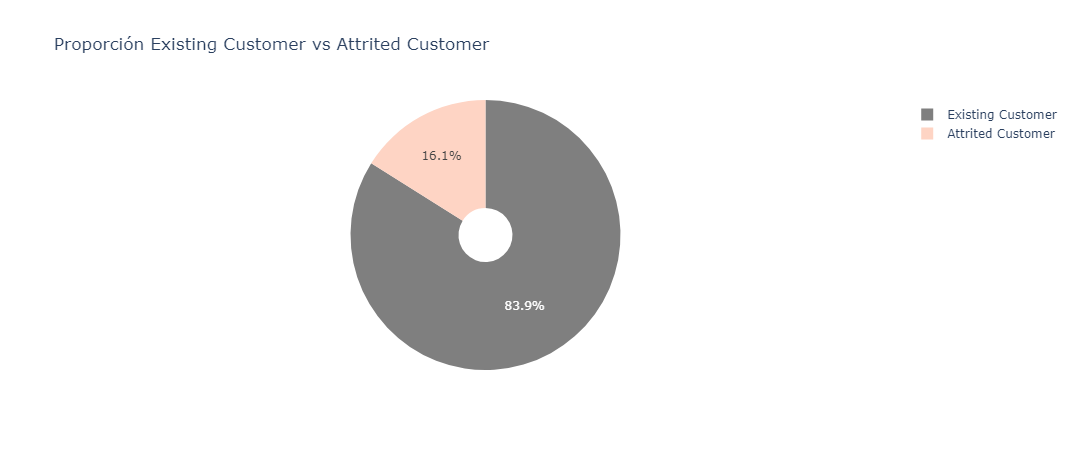

Sin nulos:
Totales: 7081
Existing Customer    5968
Attrited Customer    1113
Name: Attrition_Flag, dtype: int64

Se pierde el 30 % de los datos de la variable target



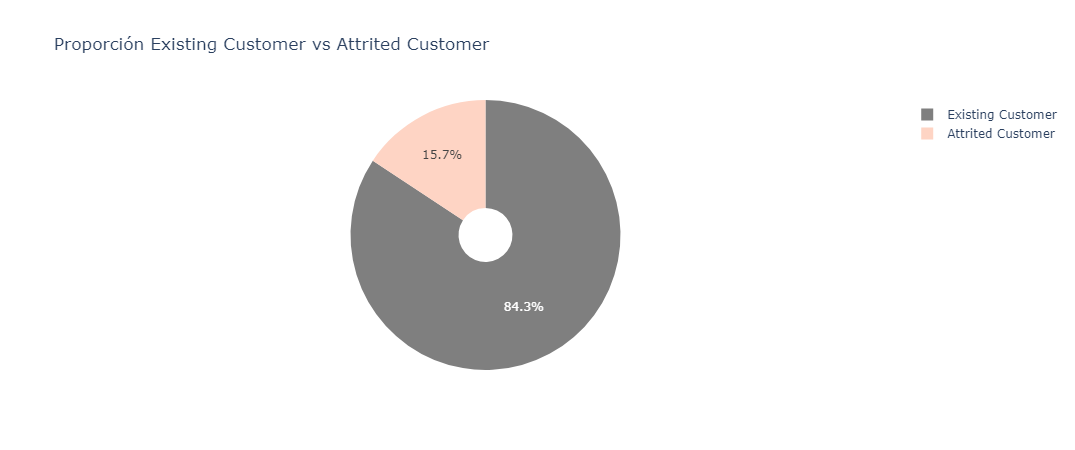

In [89]:
df_nonulo=df.dropna()

totales_con_nulos = df.Attrition_Flag.count()
print(f'Con nulos:\nTotales: {totales_con_nulos}')
print(f'{df.Attrition_Flag.value_counts()}\n')

fig = px.pie(df,names='Attrition_Flag',title='Proporción Existing Customer vs Attrited Customer',hole=0.2, color_discrete_sequence=['#7F7F7F','#FED4C4'])
fig.show()

totales_sin_nulos = df_nonulo.Attrition_Flag.count()
print(f'Sin nulos:\nTotales: {totales_sin_nulos}')
print(f'{df_nonulo.Attrition_Flag.value_counts()}\n')
print(f'Se pierde el {round(100*((totales_con_nulos - totales_sin_nulos) / totales_con_nulos) )} % de los datos de la variable target\n')

fig = px.pie(df_nonulo,names='Attrition_Flag',title='Proporción Existing Customer vs Attrited Customer',hole=0.2, color_discrete_sequence=['#7F7F7F','#FED4C4'])
fig.show()
#No se desbalancea tanto pero perdemos 600 datos target

Al borrar los datos nulos se pierde el 30% de la variable Target. Vamos a probar en los modelos si las variables con nulos son relevantes para el modelo, o si podemos evitar perder tantos registros eliminando las variables.  


Vamos a analizar algunas relaciones entre los datos:

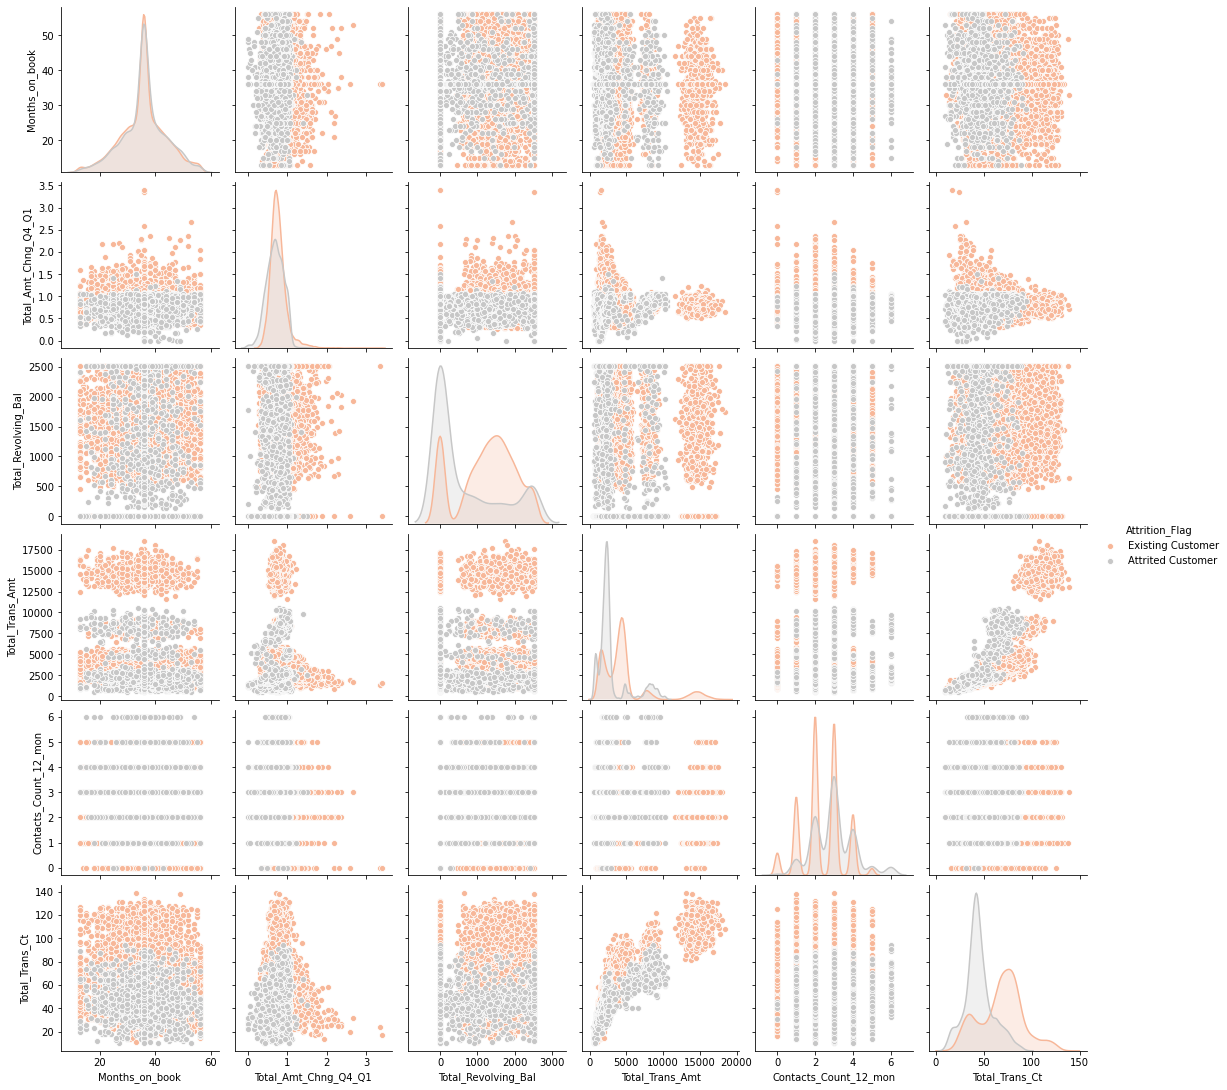

In [90]:
sns.pairplot(df[['Attrition_Flag','Months_on_book','Total_Amt_Chng_Q4_Q1','Total_Revolving_Bal','Total_Trans_Amt','Contacts_Count_12_mon','Total_Trans_Ct']],hue='Attrition_Flag', palette="RdGy");

Se puede identificarq ciertas caracteristicas de clientes que abandonaron el banco, como por ejemplo:
* Una clara distinción según el total transaction amount con límite cercano a 10.000.
* Una clara distinción en clientes que tuvieron menos de 80 transacciones totales y no usaron mucho la tarjeta el último año.

Visualizamos algunas variables en boxplots:

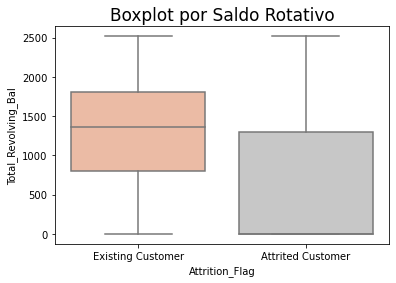

In [91]:
box=sns.boxplot(x="Attrition_Flag", y="Total_Revolving_Bal", data=df_nonulo,palette="RdGy")
box.set_title("Boxplot por Saldo Rotativo",size=17);

Se observan claras diferencias de mediana y concentración de datos entre los que dejaron el banco y los que no a partir de su saldo rotativo.

Text(0.5, 1.0, 'Boxplot por Cantidad de Productos ')

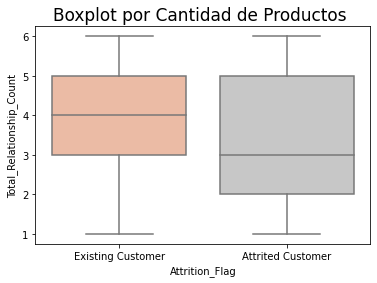

In [92]:
box=sns.boxplot(x="Attrition_Flag", y="Total_Relationship_Count", data=df_nonulo,palette="RdGy")
box.set_title("Boxplot por Cantidad de Productos ",size=17)

Se observa que quienes dejan de ser clientes tienden a tener menor cantidad de productos con el banco.

Text(0.5, 1.0, 'Boxplot por Cantidad de Transacciones')

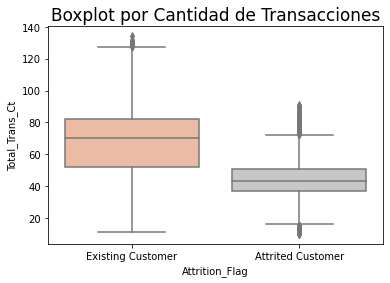

In [93]:
box=sns.boxplot(x="Attrition_Flag", y="Total_Trans_Ct", data=df_nonulo,palette="RdGy")
box.set_title("Boxplot por Cantidad de Transacciones",size=17)

Estas diferencias indican que quienes dejan el banco suelen haber realizado pocas transacciones.

Text(0.5, 1.0, 'Boxplot por Cantidad de Contactos con el banco last 12m')

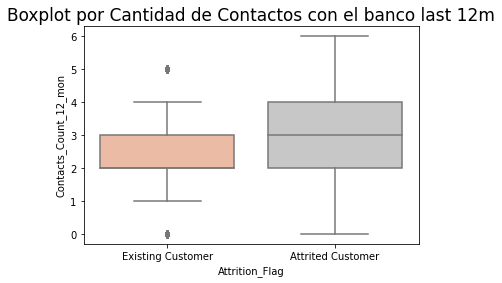

In [94]:
box=sns.boxplot(x="Attrition_Flag", y="Contacts_Count_12_mon", data=df_nonulo,palette="RdGy")
box.set_title("Boxplot por Cantidad de Contactos con el banco last 12m",size=17)

El breve análisis realizado indica que hay ciertos comportamientos característicos de los clientes que se dan de baja.  
Todo indica que son aquellos que usan poco la tarjeta, tienen pocos productos, con un saldo rotativo menor a 10.000 usd y en los ultimos 12 meses tuvieron varios contactos con el banco.

<a id="section_modelado"></a> 
# 3 - Modelado
[volver a TOC](#section_toc)

<a id="section_clasnulo"></a> 
### a. Clasificador Nulo
[volver a TOC](#section_toc)

Iniciamos testeando una indicación de accuracy generada por el clasificador nulo, solo como un baseline y entendimiento de desbalanceo de datos.

In [95]:
categoricas=categorical_columns.copy()
categoricas.remove('Attrition_Flag')
df_nonulo['Attrition_Flag'].value_counts()

Existing Customer    5968
Attrited Customer    1113
Name: Attrition_Flag, dtype: int64

In [96]:
#Convertimos la variable target a binaria
df_nonulo.Attrition_Flag.replace('Attrited Customer',1,inplace=True)
df_nonulo.Attrition_Flag.replace('Existing Customer',0,inplace=True)

C:\Users\Gonza\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [97]:
#Dividir el dataset & hacer dummies
X_nodummie = df_nonulo.drop(['Attrition_Flag','CLIENTNUM'], axis=1)
Y = df_nonulo['Attrition_Flag']
X=pd.get_dummies(X_nodummie,columns=categoricas,drop_first=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1237,stratify=Y)

print(f'Stratify Train: \n{Y_train.value_counts(normalize=True)} \n')
print(f'Stratify Test: \n{Y_test.value_counts(normalize=True)}')

Stratify Train: 
0    0.842817
1    0.157183
Name: Attrition_Flag, dtype: float64 

Stratify Test: 
0    0.842824
1    0.157176
Name: Attrition_Flag, dtype: float64


In [98]:
# Modelo más simple: Clasificador Nulo
Y_test.value_counts(normalize=True)
Y_test.mean()
Y_pred=np.full(Y_test.shape[0],0)
print(f'\nAccuracy {round(1.0 - Y_test.mean(),2)}')


Accuracy 0.84


<a id="section_multinomialnulo"></a> 
### b.MultinomialNB categóricas
[volver a TOC](#section_toc)

Dado que las columnas con nulos son solo categóricas, analizamos separarando las variables categóricas de las numéricas y probamos hacer un modelo combinado:  para variables categóricas usar MultinomialNB, para las numéricas usar GaussianNB. Luego, usando como features las predicciones resultantes de ambos modelos unificar en un solo modelo GaussianNB y de allí obtener la predicciones.  
Comenzamos analizando el modelo MultinomialNB para categóricas.

In [99]:
#Primero definimos nuestros x e y utilizando únicamente las features categoricas del dataset 'df_nonulo'
X_pipe_categoricas_nonulo = pd.get_dummies(df_nonulo[['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']],drop_first=True)
Y_pipe_nonulo = df_nonulo['Attrition_Flag']

#Armamos la division entre train y test
X_train_pipe_cat_nonulo, X_test_pipe_cat_nonulo, y_train_pipe_nonulo, y_test_pipe_nonulo = train_test_split(X_pipe_categoricas_nonulo, Y_pipe_nonulo, test_size = 0.3, random_state = 1237,stratify=Y_pipe_nonulo)

#Instanciamos un pipeline y seteamos sus parámetros:
pipeline_MultinomialNB = Pipeline([('MultinomialNB', MultinomialNB())])
param_grid_MultinomialNB = {'MultinomialNB__alpha': np.linspace(0.000001,0.01,20)}
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

#Instanciamos el modelo
grid_search_MultinomialNB_categoricas_nonulo = GridSearchCV (pipeline_MultinomialNB, param_grid_MultinomialNB,cv=folds, n_jobs=5)
grid_search_MultinomialNB_categoricas_nonulo.fit(X_train_pipe_cat_nonulo,y_train_pipe_nonulo);

#Predicciones
y_pred_MultinomialNB_nonulo = grid_search_MultinomialNB_categoricas_nonulo.best_estimator_.predict(X_test_pipe_cat_nonulo)

print(f'Mejor combinación de parámetros de modelo MultinomialNB no nulo: \n\n{grid_search_MultinomialNB_categoricas_nonulo.best_params_} \n')
print(f'Recall: {recall_score(y_test_pipe_nonulo,y_pred_MultinomialNB_nonulo)}')
print(f'Precision: {precision_score(y_test_pipe_nonulo,y_pred_MultinomialNB_nonulo)}')
print(f'F1 Score: {f1_score(y_test_pipe_nonulo,y_pred_MultinomialNB_nonulo)}')

Mejor combinación de parámetros de modelo MultinomialNB no nulo: 

{'MultinomialNB__alpha': 1e-06} 

Recall: 0.0
Precision: 0.0
F1 Score: 0.0


C:\Users\Gonza\.conda\envs\digitalhouse\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



<div class="alert alert-block alert-info"> Un modelo que sólo contemple las variables categóricas predice todas las observaciones como clientes que continuan en la cartera (clase mayoritaria, es decir igual que el clasificador nulo). Esto nos dice que las columnas categóricas por sí solas no logran generar ninguna predicción. A partir de esta conclusión los modelos los entrenamos únicamente con las variables continuas, evitando así perder el 30% de las observaciones o realizando imputaciones incorrectas que puedan alterar la realidad el dataset. </div>

<a id="section_supuestos"></a> 
### Armado de supuestos geneales para todos los modelos
[volver a TOC](#section_toc)

In [100]:
numerical_columns.remove('CLIENTNUM')

In [101]:
#Armado del dataset sólo numérico
df_limpio=df.copy()
df_limpio.Attrition_Flag.replace('Attrited Customer',1,inplace=True)
df_limpio.Attrition_Flag.replace('Existing Customer',0,inplace=True)

#X e Y a usar
X_pipe = df_limpio[numerical_columns]
Y_pipe = df_limpio['Attrition_Flag']

#Scalers
lista_scalers = [StandardScaler(),MinMaxScaler(),RobustScaler(),None]

#Folds
folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

#Train Test Split
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(X_pipe, Y_pipe, test_size = 0.3, random_state = 1237,stratify=Y_pipe)

Como aclaración general, cada modelo contará con un pipeline, un listado de parámetros, y un grid search con cross validation para asegurarnos de obtener el mejor modelo posible.

<a id="section_log"></a> 
### c. Logistic Regression
[volver a TOC](#section_toc)

In [102]:
#Pipeline
pipeline_Log = Pipeline([('scaler',StandardScaler()),('log',LogisticRegression(solver='liblinear'))])

#Grilla de parámetros
param_grid_Log = {'scaler': lista_scalers,'log__penalty': ['l1', 'l2'],'log__C': np.linspace(0.1,0.5,50)}

#Grid Search
grid_search_Log = GridSearchCV (pipeline_Log, param_grid_Log, cv=folds, n_jobs = 5,scoring='f1')

#Fit
grid_search_Log.fit(X_train_pipe, y_train_pipe)

print(f'Mejor combinación de parametros de modelo Regresión Logística: \n\n{grid_search_Log.best_params_} \n')

Mejor combinación de parametros de modelo Regresión Logística: 

{'log__C': 0.4346938775510204, 'log__penalty': 'l2', 'scaler': StandardScaler()} 



In [103]:
#Predicciones
y_pred_Log = grid_search_Log.best_estimator_.predict(X_test_pipe)

#### Scores Regresión Logística

In [104]:
print(f'Recall: {round(recall_score(y_test_pipe,y_pred_Log),4)}')
print(f'Precision: {round(precision_score(y_test_pipe,y_pred_Log),4)}')
print(f'F1 Score: {round(f1_score(y_test_pipe,y_pred_Log),4)}')

Recall: 0.5635
Precision: 0.7493
F1 Score: 0.6433


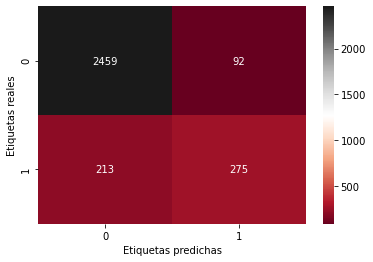

In [105]:
sns.heatmap(confusion_matrix(y_test_pipe, y_pred_Log), annot=True, fmt='.0f',cmap="RdGy")
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

<a id="section_KNN"></a> 
### d. KNN
[volver a TOC](#section_toc)

In [106]:
#Pipeline:
pipeline_KNN = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier())])

#Grilla de parámetros
param_grid_KNN = {'scaler': lista_scalers, 'knn__n_neighbors': range(2,10),'knn__weights':['uniform','distance'] } 

#Grid Search
grid_search_KNN = GridSearchCV (pipeline_KNN, param_grid_KNN, cv=folds, n_jobs = 5,scoring='f1')

#Fit
grid_search_KNN.fit(X_train_pipe, y_train_pipe)

print(f'Mejor combinación de parametros de modelo KNN: \n\n{grid_search_KNN.best_params_} \n')

Mejor combinación de parametros de modelo KNN: 

{'knn__n_neighbors': 8, 'knn__weights': 'distance', 'scaler': StandardScaler()} 



In [107]:
#Predicciones
y_pred_KNN = grid_search_KNN.best_estimator_.predict(X_test_pipe)

#### Scores KNN

In [108]:
print(f'Recall: {round(recall_score(y_test_pipe,y_pred_KNN),4)}')
print(f'Precision: {round(precision_score(y_test_pipe,y_pred_KNN),4)}')
print(f'F1 Score: {round(f1_score(y_test_pipe,y_pred_KNN),4)}')

Recall: 0.6455
Precision: 0.84
F1 Score: 0.73


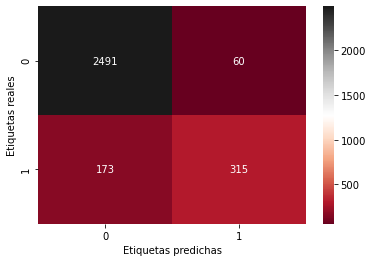

In [109]:
sns.heatmap(confusion_matrix(y_test_pipe, y_pred_KNN), annot=True, fmt='.0f',cmap="RdGy")
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

<a id="section_GaussianNB"></a> 
### e. Gaussian NB
[volver a TOC](#section_toc)

In [110]:
#Pipeline
pipeline_GaussianNB = Pipeline([('scaler',StandardScaler()),('GaussianNB',GaussianNB())])

#Grilla de parámetros
param_grid_GaussianNB = {'scaler': lista_scalers } 

#Grid Search
grid_search_GaussianNB = GridSearchCV (pipeline_GaussianNB, param_grid_GaussianNB, cv=folds, n_jobs = 5,scoring='f1')

#Fit
grid_search_GaussianNB.fit(X_train_pipe,y_train_pipe);

print(f'Mejor combinación de parametros de modelo GaussianNB: \n\n{grid_search_GaussianNB.best_params_} \n')

Mejor combinación de parametros de modelo GaussianNB: 

{'scaler': None} 



In [111]:
#Predicciones
y_pred_GaussianNB = grid_search_GaussianNB.best_estimator_.predict(X_test_pipe)

#### Scores GaussianNB

In [112]:
print(f'Recall: {round(recall_score(y_test_pipe,y_pred_GaussianNB),4)}')
print(f'Precision: {round(precision_score(y_test_pipe,y_pred_GaussianNB),4)}')
print(f'F1 Score: {round(f1_score(y_test_pipe,y_pred_GaussianNB),4)}')

Recall: 0.6127
Precision: 0.6765
F1 Score: 0.643


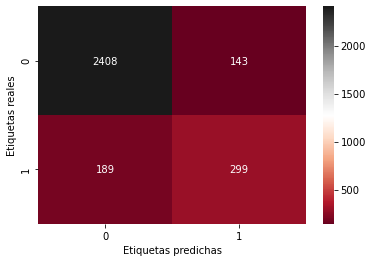

In [113]:
sns.heatmap(confusion_matrix(y_test_pipe, y_pred_GaussianNB), annot=True, fmt='.0f',cmap="RdGy")
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

<a id="section_svm"></a> 
### f. SVM
[volver a TOC](#section_toc)

In [114]:
#Pipeline
pipeline_svm = Pipeline([('scaler',StandardScaler()),('svm',SVC(probability = True))])

#Grilla de parámetros
#Real utilizado - Lo comentamos por el tiempo que demora y creamos uno que se genere mas rapido, pero si se quiere se puede volver a correr el original con el que seteamos el modelo:
#param_grid_svm = {'svm__C':[0.1,1,10,100] ,'svm__kernel':['rbf','sigmoid'],'svm__gamma':[1,0.1,0.01],'scaler': lista_scalers}
param_grid_svm = {'svm__C':[10] ,'svm__kernel':['rbf'],'svm__gamma':[0.1],'scaler': lista_scalers}

#Grid Search
grid_search_svm = GridSearchCV (pipeline_svm, param_grid_svm, cv=folds, n_jobs = 5,scoring='f1')

#Fit
grid_search_svm.fit(X_train_pipe, y_train_pipe)

print(f'Mejor combinación de parámetros de modelo SVM: \n\n{grid_search_svm.best_params_} \n')

Mejor combinación de parámetros de modelo SVM: 

{'scaler': RobustScaler(), 'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'} 



In [115]:
#Predicciones
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test_pipe)

#### Scores SVM

In [116]:
print(f'Recall: {round(recall_score(y_test_pipe,y_pred_svm),4)}')
print(f'Precision: {round(precision_score(y_test_pipe,y_pred_svm),4)}')
print(f'F1 Score: {round(f1_score(y_test_pipe,y_pred_svm),4)}')

Recall: 0.7828
Precision: 0.8604
F1 Score: 0.8197


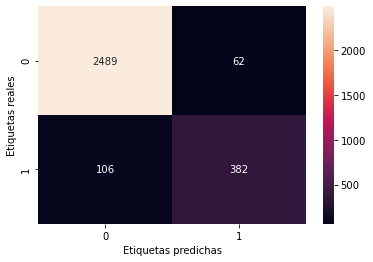

In [117]:
sns.heatmap(confusion_matrix(y_test_pipe, y_pred_svm), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

<a id="section_svm_pca"></a> 
### g. SVM con PCA
[volver a TOC](#section_toc)

In [132]:
#Pipeline
pipeline_svm_pca = Pipeline([('scaler',StandardScaler()),('preprocessing',PCA(n_components=3)),('svm',SVC(probability=True))])

#Grilla de parámetros
#Real utilizado - Lo comentamos por el tiempo que demora y creamos uno que se genere mas rapido, pero si se quiere se puede volver a correr el original con el que seteamos el modelo:
#param_grid_svm_pca = {'svm__C':[0.1,1,10,100] ,'svm__kernel':['rbf','sigmoid'],'svm__gamma':[1,0.1,0.01],'scaler': lista_scalers,'preprocessing__n_components':range(2,10,2)}
param_grid_svm_pca = {'svm__C':[10] ,'svm__kernel':['rbf'],'svm__gamma':[0.1],'scaler': lista_scalers,'preprocessing__n_components':range(2,10,2)}

#Grid Search
grid_search_svm_pca = GridSearchCV (pipeline_svm_pca, param_grid_svm_pca, cv=folds, n_jobs = 5)

#Fit
grid_search_svm_pca.fit(X_train_pipe, y_train_pipe)

print(f'Mejor combinación de parámetros de modelo SVM: \n\n{grid_search_svm_pca.best_params_} \n')

Mejor combinación de parámetros de modelo SVM: 

{'preprocessing__n_components': 8, 'scaler': RobustScaler(), 'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'} 



In [133]:
#Predicciones
y_pred_svm_pca = grid_search_svm_pca.best_estimator_.predict(X_test_pipe)

#### Scores SVM con PCA

In [134]:
print(f'Recall: {round(recall_score(y_test_pipe,y_pred_svm_pca),4)}')
print(f'Precision: {round(precision_score(y_test_pipe,y_pred_svm_pca),4)}')
print(f'F1 Score: {round(f1_score(y_test_pipe,y_pred_svm_pca),4)}')

Recall: 0.6168
Precision: 0.8048
F1 Score: 0.6984


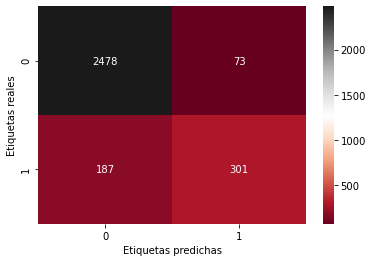

In [135]:
sns.heatmap(confusion_matrix(y_test_pipe, y_pred_svm_pca), annot=True, fmt='.0f',cmap='RdGy')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

<a id="section_graficos"></a> 
# 4- Gráficos comparativos de los modelos

[volver a TOC](#section_toc)

Vamos a visualiar las diferentes metricas para cada modelo testeado.

In [136]:
valores = [f1_score(y_test_pipe,y_pred_KNN),precision_score(y_test_pipe,y_pred_KNN),recall_score(y_test_pipe,y_pred_KNN),accuracy_score(y_test_pipe,y_pred_KNN),
          f1_score(y_test_pipe,y_pred_Log),precision_score(y_test_pipe,y_pred_Log),recall_score(y_test_pipe,y_pred_Log),accuracy_score(y_test_pipe,y_pred_Log),
          f1_score(y_test_pipe,y_pred_GaussianNB),precision_score(y_test_pipe,y_pred_GaussianNB),recall_score(y_test_pipe,y_pred_GaussianNB),accuracy_score(y_test_pipe,y_pred_GaussianNB),
          f1_score(y_test_pipe,y_pred_svm),precision_score(y_test_pipe,y_pred_svm),recall_score(y_test_pipe,y_pred_svm),accuracy_score(y_test_pipe,y_pred_svm),
          f1_score(y_test_pipe,y_pred_svm_pca),precision_score(y_test_pipe,y_pred_svm_pca),recall_score(y_test_pipe,y_pred_svm_pca),accuracy_score(y_test_pipe,y_pred_svm_pca)]

In [137]:
diccionario_plot = {'modelo':['KNN']*4 + ['Logistic Regression']*4 + ['GaussianNB']*4 + ['SVM']*4 + ['SVM_PCA']*4,
                   'score':['F1','Precision','Recall','Accuracy','F1','Precision','Recall','Accuracy','F1','Precision','Recall','Accuracy','F1','Precision','Recall','Accuracy','F1','Precision','Recall','Accuracy'],
                   'valores':valores}

In [138]:
df_plot_barras = pd.DataFrame(diccionario_plot)

In [139]:
df_plot_barras

,modelo,score,valores
0,KNN,F1,0.730012
1,KNN,Precision,0.840000
2,KNN,Recall,0.645492
3,KNN,Accuracy,0.923330
4,Logistic Regression,F1,0.643275
5,Logistic Regression,Precision,0.749319
6,Logistic Regression,Recall,0.563525
7,Logistic Regression,Accuracy,0.899638
8,GaussianNB,F1,0.643011
9,GaussianNB,Precision,0.676471


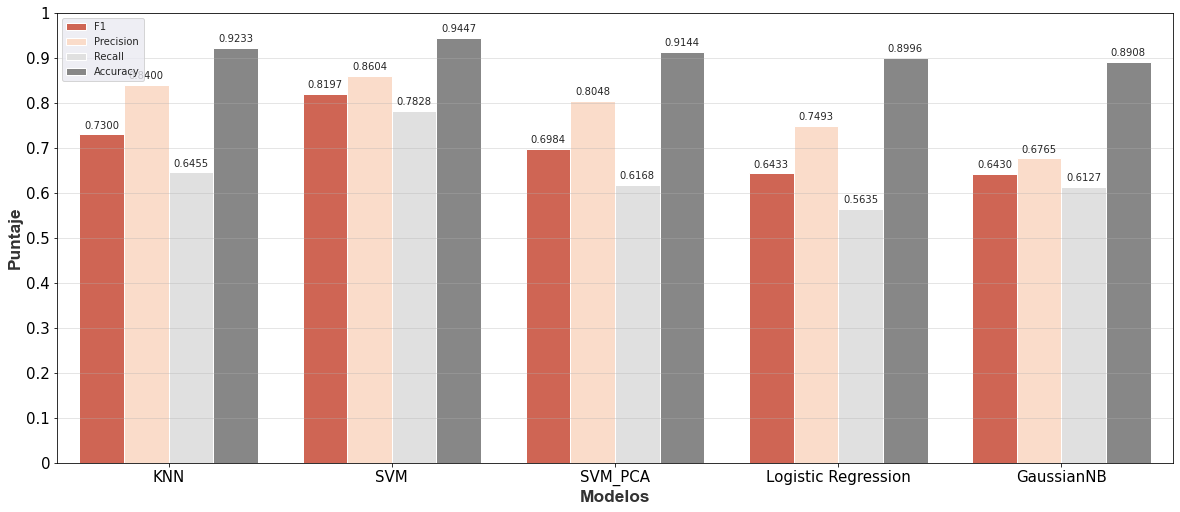

In [140]:
dims = (20,8.27)
fig,ax = plt.subplots(figsize=dims)
with sns.axes_style('darkgrid'):
    g = sns.barplot('modelo','valores',data=df_plot_barras,hue='score',palette='RdGy',ax=ax,saturation=0.9,order=['KNN','SVM','SVM_PCA','Logistic Regression','GaussianNB'])
    g.set_xlabel('Modelos',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_ylabel('Puntaje',weight='bold',size='xx-large',alpha=0.8,family= 'Arial',stretch='extra-expanded')
    g.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    g.set_xticklabels(['KNN','SVM','SVM_PCA','Logistic Regression','GaussianNB'],size=15)
    g.set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'],size=15)
    g.legend(loc=2)
    g.grid(axis='y',alpha=0.4)
    figure = g.get_figure()    
    for p in g.patches:
        g.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Observamos que es el modelo SVM el que maximiza el F1 score, y que además, maxima todos los scores evaluados.

Evaluaremos ahora el área debajo de la curva ROC de cada modelo.

In [141]:
y_pred_proba_svm_pca = grid_search_svm_pca.best_estimator_.predict_proba(X_test_pipe)

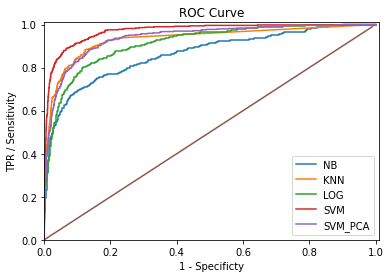

AUC KNN = 0.9326
AUC Log = 0.913
AUC NB  = 0.8636
AUC SVM = 0.9703
AUC SVM_PCA = 0.9392


In [142]:
y_pred_proba_log = grid_search_Log.best_estimator_.predict_proba(X_test_pipe)
y_pred_proba_NB = grid_search_GaussianNB.best_estimator_.predict_proba(X_test_pipe)
y_pred_proba_knn = grid_search_KNN.best_estimator_.predict_proba(X_test_pipe)
y_pred_proba_svm = grid_search_svm.best_estimator_.predict_proba(X_test_pipe)
y_pred_proba_svm_pca = grid_search_svm_pca.best_estimator_.predict_proba(X_test_pipe)

fpr_log, tpr_log , thr_log = roc_curve(y_test_pipe, y_pred_proba_log[:,1])
fpr_NB, tpr_NB, thr_NB = roc_curve(y_test_pipe, y_pred_proba_NB[:,1])
fpr_knn, tpr_knn , thr_knn = roc_curve(y_test_pipe, y_pred_proba_knn[:,1])
fpr_svm, tpr_svm , thr_svm = roc_curve(y_test_pipe, y_pred_proba_svm[:,1])
fpr_svm_pca, tpr_svm_pca, thr_svm_pca = roc_curve(y_test_pipe, y_pred_proba_svm_pca[:,1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_NB,tpr_NB)
plt.plot(fpr_knn,tpr_knn)
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_svm,tpr_svm)
plt.plot(fpr_svm_pca,tpr_svm_pca)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['NB','KNN','LOG', 'SVM','SVM_PCA'])
plt.show()

print('AUC KNN =', round(auc(fpr_knn, tpr_knn),4))
print('AUC Log =', round(auc(fpr_log, tpr_log),4))
print('AUC NB  =', round(auc(fpr_NB, tpr_NB),4))
print('AUC SVM =', round(auc(fpr_svm, tpr_svm),4))
print('AUC SVM_PCA =', round(auc(fpr_svm_pca, tpr_svm_pca),4))

Volvemos a comprobar que la mejor performance es la del modelo SVM.

<a id="section_conclusion"></a> 
# 5- Conclusión

[volver a TOC](#section_toc)

Tras el análisis de las predicciones de los distintos modelos que fueron probados, optamos por el uso de SVM que maximiza la métrica elegida con un score del 82%.
En detalle, este modelo logra capturar el 78% de los casos que serían bajas (Recall) y predice los casos en que un cliente se da de baja con una una probabilidad del 86% de que dicha predicción sea correcta.
Podemos también asegurar que las variables categóricas, no tienen influencia en la predicción del estado de un cliente.  
Además podemos aconsejar al banco prestar atención al comportamiento de los clientes, ya que quienes no realizan muchas transacciones, usan pocos productos y se comunican muchas veces con el banco, tienden a decidir darse de baja.